In [1]:
import os
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data_frame['filename'].iloc[index])
        caption = self.data_frame['impression'].iloc[index]

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, caption

In [8]:
image_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\Indiana University - Chest X-Rays\images\images"
image_caption_csv_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\Indiana University - Chest X-Rays\indiana_chest_xray_captions.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ChestXrayDataset(csv_file=image_caption_csv_path, img_dir=image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

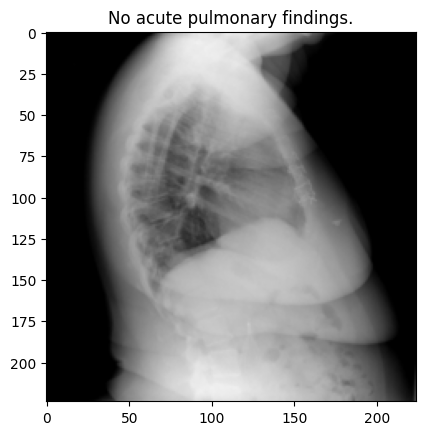

In [9]:
image, caption = dataset.__getitem__(3)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{caption}")
plt.show()

In [10]:
class ImageTextMatching(nn.Module):
    def __init__(self, vision_model, text_model, hidden_size):
        super(ImageTextMatching, self).__init__()
        self.vision_model = vision_model  # Vision Transformer (ViT) for images
        self.text_model = text_model  # Text Transformer (BERT) for text
        self.hidden_size = hidden_size
        
        # Projection layer to map (2 * hidden_size) to (hidden_size)
        self.projection = nn.Linear(2 * hidden_size, hidden_size)
        
        # Linear layer as the classification head for ITM task
        self.cls_head = nn.Linear(hidden_size, 2)  # Output logits for match/mismatch

    def forward(self, images, input_ids, attention_mask, generate_negatives=True):
        """
        Forward pass for the ITM task with positive and negative pairs.
        
        Parameters:
        - images: torch.Tensor, shape (B, C, H, W) - Batch of images.
        - input_ids: torch.Tensor, shape (B, T) - Tokenized text inputs.
        - attention_mask: torch.Tensor, shape (B, T) - Attention mask for text.
        - generate_negatives: bool - Whether to generate negative pairs.

        Returns:
        - logits: torch.Tensor, shape (2B, 2) - Logits for positive and negative pairs.
        - labels: torch.Tensor, shape (2B) - Ground-truth labels for each pair.
        """
        # 1. Extract image embeddings using vision model
        image_outputs = self.vision_model(pixel_values=images)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use CLS token embedding

        # 2. Extract text embeddings using text model
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # Use CLS token embedding
        
        # Combine image and text embeddings to form positive and negative pairs
        if generate_negatives:
            positive_pairs, negative_pairs, labels = self.create_pairs(image_embeddings, text_embeddings)
        else:
            # Use only positive pairs (no negative samples)
            positive_pairs = torch.cat((image_embeddings, text_embeddings), dim=-1)
            labels = torch.ones(positive_pairs.size(0), dtype=torch.long, device=images.device)
        
        # Concatenate positive and negative pairs
        pairs = torch.cat([positive_pairs, negative_pairs], dim=0) if generate_negatives else positive_pairs
        labels = torch.cat([labels, 1 - labels], dim=0) if generate_negatives else labels

        # Project pairs from (2 * hidden_size) to (hidden_size)
        projected_pairs = self.projection(pairs)
        
        # 4. Pass through classification head to get logits for match/mismatch
        logits = self.cls_head(projected_pairs)
        
        return logits, labels

    def create_pairs(self, image_embeddings, text_embeddings):
        """
        Create positive and negative pairs from image and text embeddings.
        
        Returns:
        - positive_pairs: torch.Tensor, shape (B, hidden_size) - Positive pairs (original).
        - negative_pairs: torch.Tensor, shape (B, hidden_size) - Negative pairs (misaligned).
        - labels: torch.Tensor, shape (B) - Labels for the pairs.
        """
        batch_size = image_embeddings.size(0)
        
        # Positive pairs
        positive_pairs = torch.cat((image_embeddings, text_embeddings), dim=-1)  # Shape (B, 2 * hidden_size)
        labels = torch.ones(batch_size, dtype=torch.long, device=image_embeddings.device)
        
        # Negative pairs - shuffle text embeddings within the batch
        shuffled_indices = torch.randperm(batch_size)
        negative_text_embeddings = text_embeddings[shuffled_indices]
        negative_pairs = torch.cat((image_embeddings, negative_text_embeddings), dim=-1)  # Shape (B, 2 * hidden_size)
        
        return positive_pairs, negative_pairs, labels


In [13]:
class ImageTextMatching(nn.Module):
    def __init__(self, vision_model, bert_model, hidden_size):
        super(ImageTextMatching, self).__init__()
        self.vision_model = vision_model  # Vision Transformer (ViT) for images
        
        # Store the full BERT model and select only the first 6 layers for the text encoder
        self.text_model = bert_model
        self.text_encoder_layers = nn.ModuleList(bert_model.encoder.layer[:6])
        self.hidden_size = hidden_size
        
        # Projection layer to map (2 * hidden_size) to (hidden_size)
        self.projection = nn.Linear(2 * hidden_size, hidden_size)
        
        # Linear layer as the classification head for ITM task
        self.cls_head = nn.Linear(hidden_size, 2)  # Output logits for match/mismatch

    def forward(self, images, input_ids, attention_mask, generate_negatives=True):
        """
        Forward pass for the ITM task with positive and negative pairs.
        
        Parameters:
        - images: torch.Tensor, shape (B, C, H, W) - Batch of images.
        - input_ids: torch.Tensor, shape (B, T) - Tokenized text inputs.
        - attention_mask: torch.Tensor, shape (B, T) - Attention mask for text.
        - generate_negatives: bool - Whether to generate negative pairs.

        Returns:
        - logits: torch.Tensor, shape (2B, 2) - Logits for positive and negative pairs.
        - labels: torch.Tensor, shape (2B) - Ground-truth labels for each pair.
        """
        # 1. Extract image embeddings using vision model
        image_outputs = self.vision_model(pixel_values=images)
        image_embeddings = image_outputs.last_hidden_state[:, 0, :]  # Use CLS token embedding

        # 2. Extract text embeddings using the first 6 layers of BERT
        text_embeddings = self.extract_text_embeddings(input_ids, attention_mask)
        
        # Combine image and text embeddings to form positive and negative pairs
        if generate_negatives:
            positive_pairs, negative_pairs, labels = self.create_pairs(image_embeddings, text_embeddings)
        else:
            # Use only positive pairs (no negative samples)
            positive_pairs = torch.cat((image_embeddings, text_embeddings), dim=-1)
            labels = torch.ones(positive_pairs.size(0), dtype=torch.long, device=images.device)
        
        # Concatenate positive and negative pairs
        pairs = torch.cat([positive_pairs, negative_pairs], dim=0) if generate_negatives else positive_pairs
        labels = torch.cat([labels, 1 - labels], dim=0) if generate_negatives else labels

        # Project pairs from (2 * hidden_size) to (hidden_size)
        projected_pairs = self.projection(pairs)
        
        # 4. Pass through classification head to get logits for match/mismatch
        logits = self.cls_head(projected_pairs)
        
        return logits, labels

    def extract_text_embeddings(self, input_ids, attention_mask):
        """
        Passes input_ids and attention_mask through the first 6 layers of BERT.
        
        Returns:
        - text_embeddings: torch.Tensor, shape (B, hidden_size)
        """
        # Pass input through the BERT embedding layer
        embeddings = self.text_model.embeddings(input_ids=input_ids)
        
        # Ensure attention_mask has the correct shape for broadcasting
        attention_mask = attention_mask[:, None, None, :]  # Shape: (batch_size, 1, 1, sequence_length)
        
        # Apply only the first 6 layers of the encoder
        for layer in self.text_encoder_layers:
            embeddings = layer(embeddings, attention_mask=attention_mask)[0]

        # Use the CLS token embedding as the text representation
        text_embeddings = embeddings[:, 0, :]  # Shape (B, hidden_size)
        
        return text_embeddings

    def create_pairs(self, image_embeddings, text_embeddings):
        """
        Create positive and negative pairs from image and text embeddings.
        
        Returns:
        - positive_pairs: torch.Tensor, shape (B, hidden_size) - Positive pairs (original).
        - negative_pairs: torch.Tensor, shape (B, hidden_size) - Negative pairs (misaligned).
        - labels: torch.Tensor, shape (B) - Labels for the pairs.
        """
        batch_size = image_embeddings.size(0)
        
        # Positive pairs
        positive_pairs = torch.cat((image_embeddings, text_embeddings), dim=-1)  # Shape (B, 2 * hidden_size)
        labels = torch.ones(batch_size, dtype=torch.long, device=image_embeddings.device)
        
        # Negative pairs - shuffle text embeddings within the batch
        shuffled_indices = torch.randperm(batch_size)
        negative_text_embeddings = text_embeddings[shuffled_indices]
        negative_pairs = torch.cat((image_embeddings, negative_text_embeddings), dim=-1)  # Shape (B, 2 * hidden_size)
        
        return positive_pairs, negative_pairs, labels

In [14]:
vision_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
text_model = BertModel.from_pretrained('bert-base-uncased')
hidden_size = vision_model.config.hidden_size  # Assuming both ViT and BERT use the same hidden size

# Initialize ITM model
itm_model = ImageTextMatching(vision_model, text_model, hidden_size).to(device)

# Sample batch of images and text inputs (assuming you have a DataLoader that provides these)
images, captions = next(iter(data_loader))
images = images.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize captions (assuming tokenizer is already defined for the text model)
tokenized = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).to(device)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

# Forward pass through the model
logits, labels = itm_model(images, input_ids, attention_mask)

# Calculate cross-entropy loss
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, labels)

print(f"ITM Loss: {loss.item()}")

ITM Loss: 0.6955817341804504


In [15]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm

def train_itm_model(itm_model, data_loader, tokenizer, device, num_epochs=3, learning_rate=1e-4, checkpoint_path="itm_checkpoint.pth"):
    """
    Train the Image-Text Matching (ITM) model with checkpointing and in-loop tokenization.

    Parameters:
    - itm_model: ImageTextMatching model instance
    - data_loader: DataLoader instance with (images, captions) batches
    - tokenizer: Tokenizer instance for processing text data
    - device: torch.device, either 'cuda' or 'cpu'
    - num_epochs: int, number of training epochs
    - learning_rate: float, learning rate for optimizer
    - checkpoint_path: str, path to save/load model checkpoint
    """
    optimizer = optim.Adam(itm_model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Load checkpoint if it exists
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        itm_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")

    for epoch in range(start_epoch, num_epochs):
        itm_model.train()
        total_loss = 0
        batch_count = len(data_loader)
        
        for i, (images, captions) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Move images to the correct device
            images = images.to(device)
            
            # Tokenize captions and move to device
            tokenized = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
            input_ids = tokenized['input_ids'].to(device)
            attention_mask = tokenized['attention_mask'].to(device)

            # Forward pass through the model to get logits and labels
            logits, labels = itm_model(images, input_ids, attention_mask)

            # Calculate cross-entropy loss
            loss = loss_fn(logits, labels)

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for reporting
            total_loss += loss.item()

            # Print progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{batch_count}], Loss: {total_loss / (i + 1):.4f}")
        
        # Average loss for the epoch
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': itm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ITM model
# Assuming `vision_model` and `text_model` are pre-initialized models (e.g., ViT and BERT)
hidden_size = vision_model.config.hidden_size  # Ensure this matches between vision and text models
itm_model = ImageTextMatching(vision_model, text_model, hidden_size).to(device)

# Initialize the data loader (assuming it provides images and captions)
# Example: data_loader = DataLoader(your_dataset, batch_size=32, shuffle=True)

# Call the training function
train_itm_model(
    itm_model=itm_model,
    data_loader=data_loader,
    tokenizer=tokenizer,
    device=device,
    num_epochs=3,  # Number of epochs
    learning_rate=1e-4,  # Learning rate
    checkpoint_path="itm_checkpoint.pth"  # Path to save model checkpoints
)

Epoch 1/3:   1%|          | 10/927 [00:03<04:06,  3.72it/s]

Epoch [1/3], Batch [10/927], Loss: 0.7467


Epoch 1/3:   2%|▏         | 20/927 [00:05<04:11,  3.60it/s]

Epoch [1/3], Batch [20/927], Loss: 0.7215


Epoch 1/3:   3%|▎         | 30/927 [00:08<04:20,  3.45it/s]

Epoch [1/3], Batch [30/927], Loss: 0.7125


Epoch 1/3:   4%|▍         | 40/927 [00:11<04:14,  3.49it/s]

Epoch [1/3], Batch [40/927], Loss: 0.7078


Epoch 1/3:   5%|▌         | 50/927 [00:14<04:01,  3.63it/s]

Epoch [1/3], Batch [50/927], Loss: 0.7049


Epoch 1/3:   6%|▋         | 60/927 [00:17<03:48,  3.79it/s]

Epoch [1/3], Batch [60/927], Loss: 0.7029


Epoch 1/3:   8%|▊         | 70/927 [00:19<03:56,  3.63it/s]

Epoch [1/3], Batch [70/927], Loss: 0.7015


Epoch 1/3:   9%|▊         | 80/927 [00:22<03:58,  3.55it/s]

Epoch [1/3], Batch [80/927], Loss: 0.7005


Epoch 1/3:  10%|▉         | 90/927 [00:25<03:39,  3.82it/s]

Epoch [1/3], Batch [90/927], Loss: 0.6997


Epoch 1/3:  11%|█         | 100/927 [00:28<03:50,  3.59it/s]

Epoch [1/3], Batch [100/927], Loss: 0.6991


Epoch 1/3:  12%|█▏        | 110/927 [00:31<03:46,  3.61it/s]

Epoch [1/3], Batch [110/927], Loss: 0.6985


Epoch 1/3:  13%|█▎        | 120/927 [00:33<03:45,  3.58it/s]

Epoch [1/3], Batch [120/927], Loss: 0.6981


Epoch 1/3:  14%|█▍        | 130/927 [00:36<03:38,  3.65it/s]

Epoch [1/3], Batch [130/927], Loss: 0.6977


Epoch 1/3:  15%|█▌        | 140/927 [00:39<03:39,  3.59it/s]

Epoch [1/3], Batch [140/927], Loss: 0.6974


Epoch 1/3:  16%|█▌        | 150/927 [00:42<03:57,  3.27it/s]

Epoch [1/3], Batch [150/927], Loss: 0.6971


Epoch 1/3:  17%|█▋        | 160/927 [00:45<03:38,  3.51it/s]

Epoch [1/3], Batch [160/927], Loss: 0.6969


Epoch 1/3:  18%|█▊        | 170/927 [00:48<03:28,  3.63it/s]

Epoch [1/3], Batch [170/927], Loss: 0.6967


Epoch 1/3:  19%|█▉        | 180/927 [00:50<03:27,  3.61it/s]

Epoch [1/3], Batch [180/927], Loss: 0.6965


Epoch 1/3:  20%|██        | 190/927 [00:53<03:28,  3.54it/s]

Epoch [1/3], Batch [190/927], Loss: 0.6963


Epoch 1/3:  22%|██▏       | 200/927 [00:56<03:18,  3.66it/s]

Epoch [1/3], Batch [200/927], Loss: 0.6961


Epoch 1/3:  23%|██▎       | 210/927 [00:59<03:22,  3.55it/s]

Epoch [1/3], Batch [210/927], Loss: 0.6960


Epoch 1/3:  24%|██▎       | 220/927 [01:01<03:19,  3.55it/s]

Epoch [1/3], Batch [220/927], Loss: 0.6959


Epoch 1/3:  25%|██▍       | 230/927 [01:04<03:13,  3.61it/s]

Epoch [1/3], Batch [230/927], Loss: 0.6958


Epoch 1/3:  26%|██▌       | 240/927 [01:07<03:13,  3.55it/s]

Epoch [1/3], Batch [240/927], Loss: 0.6957


Epoch 1/3:  27%|██▋       | 250/927 [01:10<03:08,  3.60it/s]

Epoch [1/3], Batch [250/927], Loss: 0.6956


Epoch 1/3:  28%|██▊       | 260/927 [01:13<02:59,  3.72it/s]

Epoch [1/3], Batch [260/927], Loss: 0.6955


Epoch 1/3:  29%|██▉       | 270/927 [01:15<02:59,  3.67it/s]

Epoch [1/3], Batch [270/927], Loss: 0.6954


Epoch 1/3:  30%|███       | 280/927 [01:18<02:51,  3.77it/s]

Epoch [1/3], Batch [280/927], Loss: 0.6953


Epoch 1/3:  31%|███▏      | 290/927 [01:21<02:56,  3.62it/s]

Epoch [1/3], Batch [290/927], Loss: 0.6952


Epoch 1/3:  32%|███▏      | 300/927 [01:23<02:55,  3.58it/s]

Epoch [1/3], Batch [300/927], Loss: 0.6952


Epoch 1/3:  33%|███▎      | 310/927 [01:26<02:53,  3.57it/s]

Epoch [1/3], Batch [310/927], Loss: 0.6951


Epoch 1/3:  35%|███▍      | 320/927 [01:29<02:45,  3.66it/s]

Epoch [1/3], Batch [320/927], Loss: 0.6950


Epoch 1/3:  36%|███▌      | 330/927 [01:32<02:44,  3.63it/s]

Epoch [1/3], Batch [330/927], Loss: 0.6950


Epoch 1/3:  37%|███▋      | 340/927 [01:35<02:46,  3.53it/s]

Epoch [1/3], Batch [340/927], Loss: 0.6949


Epoch 1/3:  38%|███▊      | 350/927 [01:37<02:41,  3.57it/s]

Epoch [1/3], Batch [350/927], Loss: 0.6949


Epoch 1/3:  39%|███▉      | 360/927 [01:40<02:36,  3.63it/s]

Epoch [1/3], Batch [360/927], Loss: 0.6948


Epoch 1/3:  40%|███▉      | 370/927 [01:43<02:29,  3.73it/s]

Epoch [1/3], Batch [370/927], Loss: 0.6948


Epoch 1/3:  41%|████      | 380/927 [01:46<02:32,  3.60it/s]

Epoch [1/3], Batch [380/927], Loss: 0.6948


Epoch 1/3:  42%|████▏     | 390/927 [01:49<02:31,  3.56it/s]

Epoch [1/3], Batch [390/927], Loss: 0.6947


Epoch 1/3:  43%|████▎     | 400/927 [01:51<02:22,  3.69it/s]

Epoch [1/3], Batch [400/927], Loss: 0.6947


Epoch 1/3:  44%|████▍     | 410/927 [01:54<02:22,  3.64it/s]

Epoch [1/3], Batch [410/927], Loss: 0.6946


Epoch 1/3:  45%|████▌     | 420/927 [01:57<02:23,  3.53it/s]

Epoch [1/3], Batch [420/927], Loss: 0.6946


Epoch 1/3:  46%|████▋     | 430/927 [02:00<02:20,  3.53it/s]

Epoch [1/3], Batch [430/927], Loss: 0.6946


Epoch 1/3:  47%|████▋     | 440/927 [02:03<02:20,  3.46it/s]

Epoch [1/3], Batch [440/927], Loss: 0.6945


Epoch 1/3:  49%|████▊     | 450/927 [02:05<02:14,  3.54it/s]

Epoch [1/3], Batch [450/927], Loss: 0.6945


Epoch 1/3:  50%|████▉     | 460/927 [02:08<02:14,  3.47it/s]

Epoch [1/3], Batch [460/927], Loss: 0.6945


Epoch 1/3:  51%|█████     | 470/927 [02:11<02:08,  3.55it/s]

Epoch [1/3], Batch [470/927], Loss: 0.6945


Epoch 1/3:  52%|█████▏    | 480/927 [02:14<02:01,  3.68it/s]

Epoch [1/3], Batch [480/927], Loss: 0.6944


Epoch 1/3:  53%|█████▎    | 490/927 [02:17<02:02,  3.57it/s]

Epoch [1/3], Batch [490/927], Loss: 0.6944


Epoch 1/3:  54%|█████▍    | 500/927 [02:19<01:59,  3.57it/s]

Epoch [1/3], Batch [500/927], Loss: 0.6944


Epoch 1/3:  55%|█████▌    | 510/927 [02:22<01:51,  3.73it/s]

Epoch [1/3], Batch [510/927], Loss: 0.6944


Epoch 1/3:  56%|█████▌    | 520/927 [02:25<01:51,  3.65it/s]

Epoch [1/3], Batch [520/927], Loss: 0.6943


Epoch 1/3:  57%|█████▋    | 530/927 [02:28<01:46,  3.73it/s]

Epoch [1/3], Batch [530/927], Loss: 0.6943


Epoch 1/3:  58%|█████▊    | 540/927 [02:30<01:45,  3.65it/s]

Epoch [1/3], Batch [540/927], Loss: 0.6943


Epoch 1/3:  59%|█████▉    | 550/927 [02:33<01:45,  3.58it/s]

Epoch [1/3], Batch [550/927], Loss: 0.6943


Epoch 1/3:  60%|██████    | 560/927 [02:36<01:45,  3.47it/s]

Epoch [1/3], Batch [560/927], Loss: 0.6943


Epoch 1/3:  61%|██████▏   | 570/927 [02:39<01:38,  3.62it/s]

Epoch [1/3], Batch [570/927], Loss: 0.6942


Epoch 1/3:  63%|██████▎   | 580/927 [02:42<01:38,  3.52it/s]

Epoch [1/3], Batch [580/927], Loss: 0.6942


Epoch 1/3:  64%|██████▎   | 590/927 [02:45<01:33,  3.61it/s]

Epoch [1/3], Batch [590/927], Loss: 0.6942


Epoch 1/3:  65%|██████▍   | 600/927 [02:47<01:33,  3.51it/s]

Epoch [1/3], Batch [600/927], Loss: 0.6942


Epoch 1/3:  66%|██████▌   | 610/927 [02:50<01:29,  3.54it/s]

Epoch [1/3], Batch [610/927], Loss: 0.6942


Epoch 1/3:  67%|██████▋   | 620/927 [02:53<01:24,  3.63it/s]

Epoch [1/3], Batch [620/927], Loss: 0.6941


Epoch 1/3:  68%|██████▊   | 630/927 [02:56<01:21,  3.63it/s]

Epoch [1/3], Batch [630/927], Loss: 0.6941


Epoch 1/3:  69%|██████▉   | 640/927 [02:59<01:20,  3.56it/s]

Epoch [1/3], Batch [640/927], Loss: 0.6941


Epoch 1/3:  70%|███████   | 650/927 [03:01<01:18,  3.55it/s]

Epoch [1/3], Batch [650/927], Loss: 0.6941


Epoch 1/3:  71%|███████   | 660/927 [03:04<01:13,  3.62it/s]

Epoch [1/3], Batch [660/927], Loss: 0.6941


Epoch 1/3:  72%|███████▏  | 670/927 [03:07<01:10,  3.63it/s]

Epoch [1/3], Batch [670/927], Loss: 0.6941


Epoch 1/3:  73%|███████▎  | 680/927 [03:10<01:08,  3.58it/s]

Epoch [1/3], Batch [680/927], Loss: 0.6941


Epoch 1/3:  74%|███████▍  | 690/927 [03:13<01:07,  3.52it/s]

Epoch [1/3], Batch [690/927], Loss: 0.6940


Epoch 1/3:  76%|███████▌  | 700/927 [03:15<01:01,  3.72it/s]

Epoch [1/3], Batch [700/927], Loss: 0.6940


Epoch 1/3:  77%|███████▋  | 710/927 [03:18<00:59,  3.65it/s]

Epoch [1/3], Batch [710/927], Loss: 0.6940


Epoch 1/3:  78%|███████▊  | 720/927 [03:21<01:00,  3.41it/s]

Epoch [1/3], Batch [720/927], Loss: 0.6940


Epoch 1/3:  79%|███████▊  | 730/927 [03:24<00:55,  3.52it/s]

Epoch [1/3], Batch [730/927], Loss: 0.6940


Epoch 1/3:  80%|███████▉  | 740/927 [03:27<00:51,  3.66it/s]

Epoch [1/3], Batch [740/927], Loss: 0.6940


Epoch 1/3:  81%|████████  | 750/927 [03:30<00:49,  3.57it/s]

Epoch [1/3], Batch [750/927], Loss: 0.6940


Epoch 1/3:  82%|████████▏ | 760/927 [03:32<00:46,  3.58it/s]

Epoch [1/3], Batch [760/927], Loss: 0.6940


Epoch 1/3:  83%|████████▎ | 770/927 [03:35<00:44,  3.54it/s]

Epoch [1/3], Batch [770/927], Loss: 0.6940


Epoch 1/3:  84%|████████▍ | 780/927 [03:38<00:41,  3.56it/s]

Epoch [1/3], Batch [780/927], Loss: 0.6940


Epoch 1/3:  85%|████████▌ | 790/927 [03:41<00:38,  3.56it/s]

Epoch [1/3], Batch [790/927], Loss: 0.6939


Epoch 1/3:  86%|████████▋ | 800/927 [03:44<00:35,  3.59it/s]

Epoch [1/3], Batch [800/927], Loss: 0.6939


Epoch 1/3:  87%|████████▋ | 810/927 [03:47<00:33,  3.52it/s]

Epoch [1/3], Batch [810/927], Loss: 0.6939


Epoch 1/3:  88%|████████▊ | 820/927 [03:49<00:29,  3.59it/s]

Epoch [1/3], Batch [820/927], Loss: 0.6939


Epoch 1/3:  90%|████████▉ | 830/927 [03:52<00:27,  3.55it/s]

Epoch [1/3], Batch [830/927], Loss: 0.6939


Epoch 1/3:  91%|█████████ | 840/927 [03:55<00:24,  3.48it/s]

Epoch [1/3], Batch [840/927], Loss: 0.6939


Epoch 1/3:  92%|█████████▏| 850/927 [03:58<00:21,  3.59it/s]

Epoch [1/3], Batch [850/927], Loss: 0.6939


Epoch 1/3:  93%|█████████▎| 860/927 [04:01<00:18,  3.57it/s]

Epoch [1/3], Batch [860/927], Loss: 0.6939


Epoch 1/3:  94%|█████████▍| 870/927 [04:03<00:16,  3.43it/s]

Epoch [1/3], Batch [870/927], Loss: 0.6939


Epoch 1/3:  95%|█████████▍| 880/927 [04:06<00:13,  3.59it/s]

Epoch [1/3], Batch [880/927], Loss: 0.6939


Epoch 1/3:  96%|█████████▌| 890/927 [04:09<00:10,  3.65it/s]

Epoch [1/3], Batch [890/927], Loss: 0.6939


Epoch 1/3:  97%|█████████▋| 900/927 [04:12<00:07,  3.46it/s]

Epoch [1/3], Batch [900/927], Loss: 0.6938


Epoch 1/3:  98%|█████████▊| 910/927 [04:15<00:05,  3.06it/s]

Epoch [1/3], Batch [910/927], Loss: 0.6938


Epoch 1/3:  99%|█████████▉| 920/927 [04:18<00:02,  3.49it/s]

Epoch [1/3], Batch [920/927], Loss: 0.6938


Epoch 1/3: 100%|██████████| 927/927 [04:20<00:00,  3.56it/s]


Epoch [1/3], Loss: 0.6938


KeyboardInterrupt: 

In [17]:
import torch
from transformers import BertTokenizer

def test_itm_model(itm_model, data_loader, tokenizer, device):
    """
    Test the ITM model on a single batch from the data loader.

    Parameters:
    - itm_model: Trained ImageTextMatching model.
    - data_loader: DataLoader providing batches of (images, captions).
    - tokenizer: Tokenizer for text processing.
    - device: torch.device, either 'cuda' or 'cpu'.
    """
    # Set the model to evaluation mode
    itm_model.eval()
    
    # Get one batch from the data loader
    images, captions = next(iter(data_loader))
    
    # Move images to device
    images = images.to(device)

    # Tokenize captions and move to device
    tokenized = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
    input_ids = tokenized['input_ids'].to(device)
    attention_mask = tokenized['attention_mask'].to(device)

    # Forward pass through the model (no gradient calculation in eval mode)
    with torch.no_grad():
        logits, labels = itm_model(images, input_ids, attention_mask)

    # Calculate predicted labels
    predicted_labels = torch.argmax(logits, dim=1)

    # Print results
    print("Ground Truth Labels:", labels.cpu().numpy())
    print("Predicted Labels:", predicted_labels.cpu().numpy())
    print("Logits:", logits.cpu().numpy())

# Example usage
# Assuming `data_loader`, `tokenizer`, `device` are already defined and `itm_model` is a trained model.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_itm_model(itm_model, data_loader, tokenizer, device)


Ground Truth Labels: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Predicted Labels: [0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1]
Logits: [[0.02925182 0.02647666]
 [0.01925311 0.02253074]
 [0.0264451  0.02262828]
 [0.03777168 0.0403425 ]
 [0.03219333 0.03049548]
 [0.03151333 0.03345614]
 [0.02856652 0.03055723]
 [0.02243552 0.02293559]
 [0.02875645 0.0299235 ]
 [0.0284641  0.02803055]
 [0.0264451  0.02262828]
 [0.03777168 0.0403425 ]
 [0.02818788 0.02569658]
 [0.02644093 0.02689609]
 [0.0240149  0.02742447]
 [0.02734932 0.02848065]]
